# Visualizing results

In [1]:
cd /home

/home


In [3]:
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np
import toml
import wandb
import toml
import glob
import os

from src.utils import get_metrics

### Summary table

In [10]:
folder = './presentation/experiments/astromer_2/results/nsp_normal/'
exp_folders = glob.glob(os.path.join(folder, '*', '*'))

In [72]:
metric_names= ['epoch_loss', 'epoch_r_square']#, 'epoch_rmse', 'epoch_bce', 'epoch_acc']

rows = []
for expdir in exp_folders:
    config_path = os.path.join(expdir, 'config.toml')
    log_dir = os.path.join(expdir, 'logs')
    
    with open(config_path, 'r') as f:
        config = toml.load(f)

    val_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name='epoch_loss')
    best_epoch = val_metrics['value'].astype(float).argmin() 
    
    for index, metric in enumerate(metric_names):
        train_metrics = get_metrics(os.path.join(log_dir, 'train'), metric_name=metric)
        valid_metrics = get_metrics(os.path.join(log_dir, 'validation'), metric_name=metric)
        
        config[metric] = np.round(train_metrics.iloc[best_epoch]['value'], 3)
        config[metric+'_val'] = np.round(valid_metrics.iloc[best_epoch]['value'], 3)
        
    # TESTING
    try:
        with open(os.path.join(expdir, 'metrics.toml'), 'r') as h:
            test_metric = toml.load(h)
            print(test_metric['test_r2'], test_metric['val_r2'])
    except:
        continue
        
        
    rows.append(pd.Series(config))
    
results = pd.concat(rows, axis=1).T
results.columns

0.9412244558334351 8.213520050048828e-05
0.3823637366294861 -0.23176109790802002
0.8889138698577881 -0.0641556978225708


Index(['exp_name', 'data', 'gpu', 'debug', 'encoder_mode', 'layers', 'nh',
       'hdim', 'pe_dim', 'mixer', 'dropout', 'avg_layers', 'lr', 'bs',
       'patience', 'epochs', 'ws', 'optimizer', 'off_nsp', 'probed', 'rs',
       'nsp_prob', 'rmse_factor', 'epoch_loss', 'epoch_loss_val',
       'epoch_r_square', 'epoch_r_square_val'],
      dtype='object')

In [58]:
def format_label(x):
    label = 'Enc: {}\n Layers: {}\n Mixer: {}\n Dropout: {:.2f}'.format(x['encoder_mode'], x['layers'], 
                                                             x['mixer'], x['dropout'])
    return label

results['tickname'] = results.apply(lambda x: format_label(x), 1) 

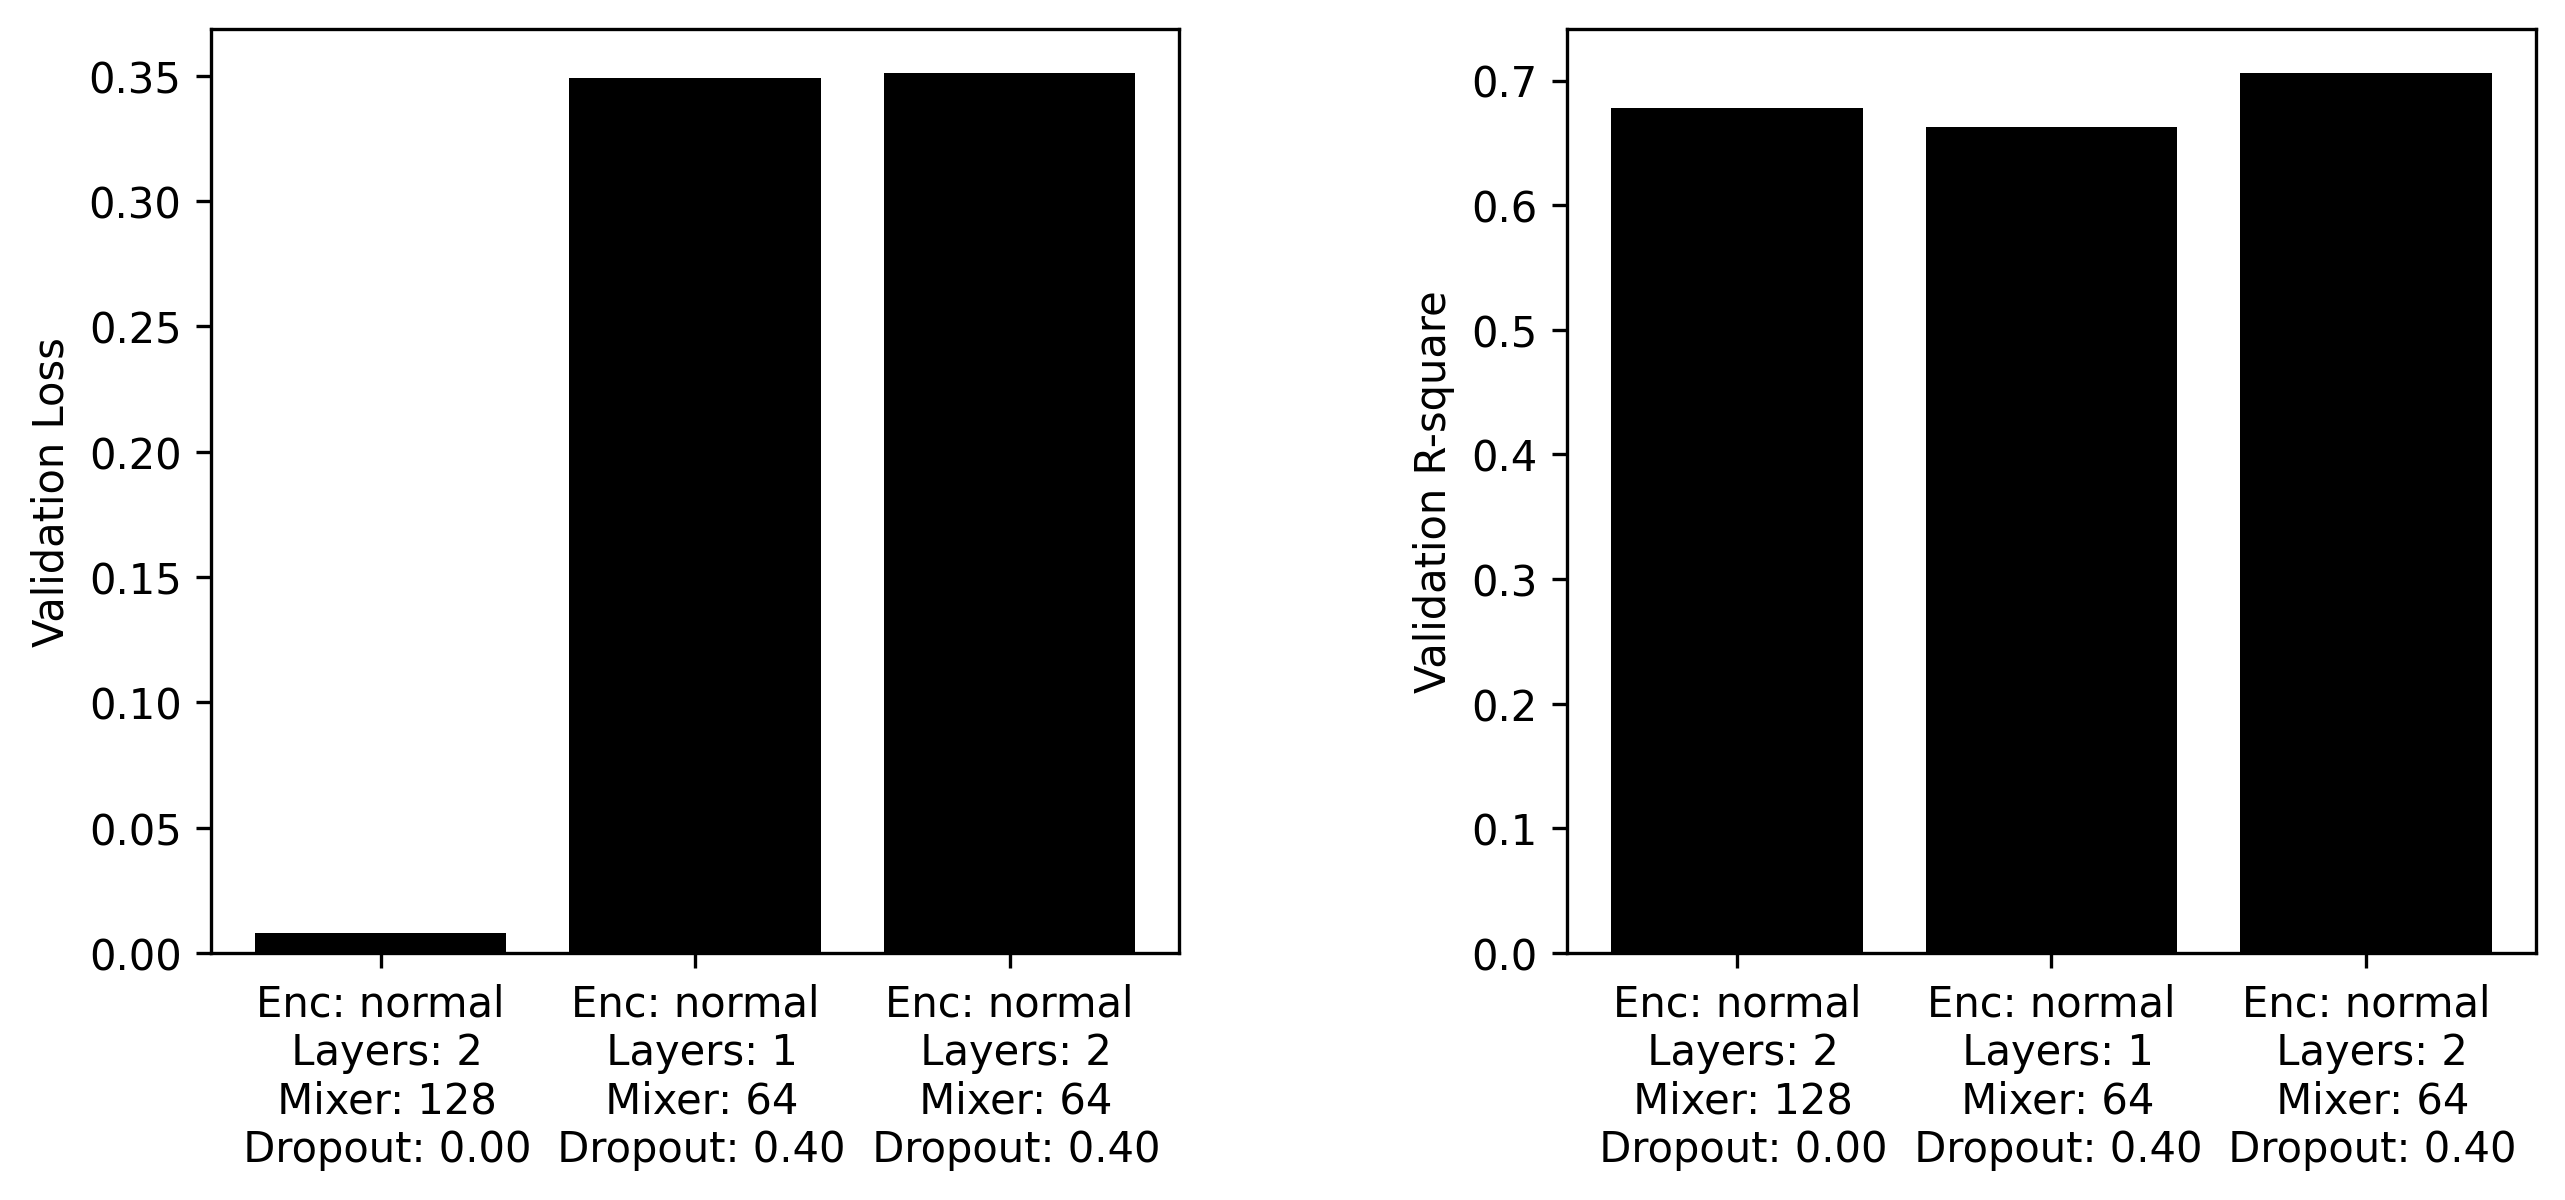

In [59]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'hspace': 0.4, 'wspace': 0.4}, dpi=300, figsize=(10, 4))
axes = axes.flatten()
labels_name = {
    'epoch_loss_val': 'Validation Loss',
    'epoch_rmse_val': 'Validation RMSE',
    'epoch_r_square_val': 'Validation R-square',
    'epoch_acc': 'Validation Accuracy',
    'epoch_bce': 'Validation Binary \n Cross-Entropy',
    }

for i, column in enumerate(['epoch_loss_val', 'epoch_r_square_val']):
    axes[i].bar(results['tickname'], results[column], color='k')
    axes[i].set_ylabel(labels_name[column])

## Testing results

{'data': './data/records/macho_clean/test',
 'training_time_sec': 33002.50585818291,
 'val_rmse': 0.015094333328306675,
 'val_r2': -0.23176109790802002,
 'train_rmse': 0.010594507679343224,
 'r2': -5.684655666351318,
 'test_rmse': 0.017740914598107338,
 'test_r2': 0.3823637366294861}

### Visualize learning curves

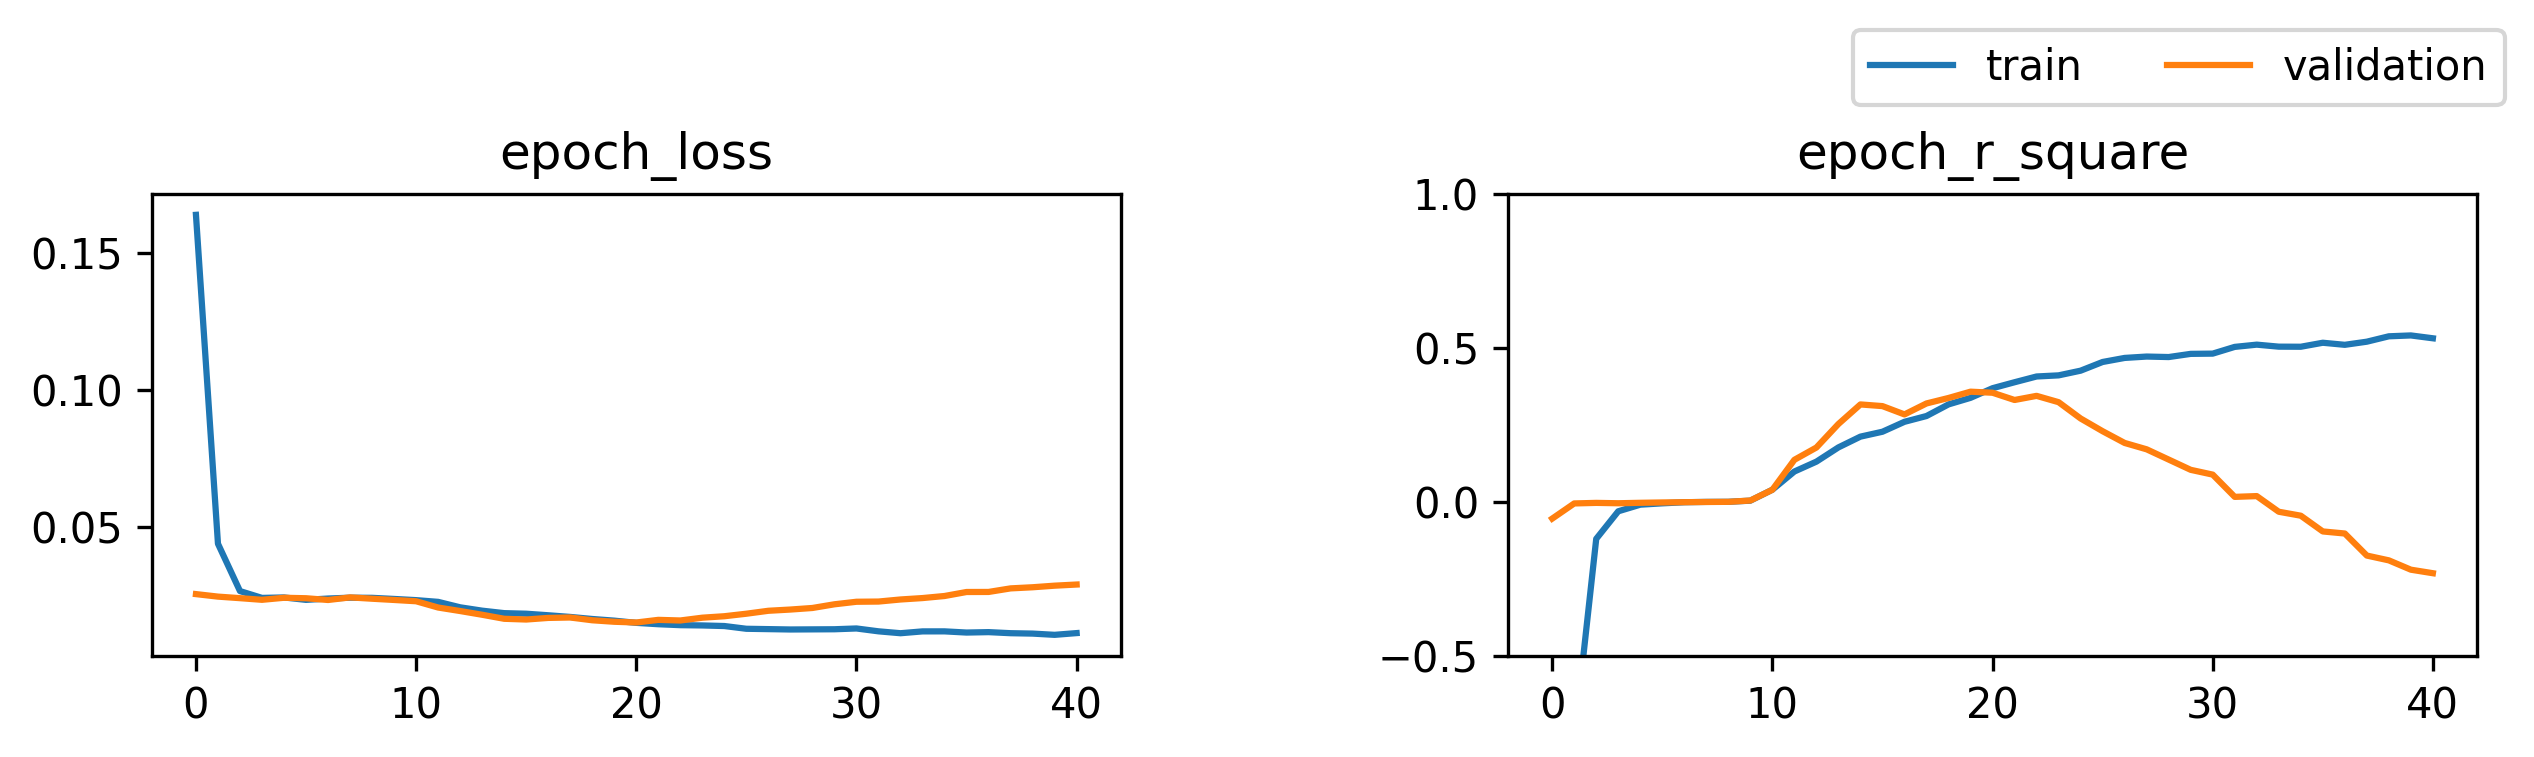

In [60]:
logs_path = './presentation/experiments/astromer_2/results/nsp_normal/2023-07-24_22-43-03/'

# metric_names= ['epoch_loss', 'epoch_rmse', 'epoch_r_square', 'epoch_bce', 'epoch_acc']
metric_names= ['epoch_loss', 'epoch_r_square']
fig, axes = plt.subplots(1, 2, figsize=(10,2), dpi=300, 
                        gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
for index, metric_name in enumerate(metric_names):
    train_metrics = get_metrics(os.path.join(logs_path, 'pretraining/logs/train'), metric_name=metric_name)
    valid_metrics = get_metrics(os.path.join(logs_path, 'pretraining/logs/validation'), metric_name=metric_name)
    
    axes[index].plot(train_metrics['value'], label='train')
    axes[index].plot(valid_metrics['value'], label='validation')
    axes[index].set_title(metric_name)

axes[1].set_ylim(-0.5, 1)
axes[-1].legend(bbox_to_anchor=(1.05, 1.4), ncols=2)

### Classification results

In [11]:
astromer_0 = pd.read_csv('./presentation/experiments/astromer_0/backup/wandb_tables/downstream.csv')

In [12]:
astromer_0_best = astromer_0[(astromer_0['clf_name'] == 'mlp_att') & \
                         (astromer_0['window_size'] == 200) & \
                         (astromer_0['probed'] == 0.4) ]
astromer_0_best = astromer_0_best[['dataset_to_ft', 'fold', 'epoch/val_accuracy']].groupby('dataset_to_ft')
astromer_0_best = astromer_0_best['epoch/val_accuracy'].mean().reset_index()

In [13]:
summary = pd.read_csv(os.path.join(folder, 'summary.csv'))
summary = summary[summary['State'] == 'finished']
summary.columns

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'clf_name', 'fold', 'pt_model', 'spc', 'subdataset', 'bs',
       'clf_test_acc', 'clf_test_f1', 'clf_test_precision', 'clf_test_recall',
       'clf_val_acc', 'clf_val_loss', 'data', 'debug', 'dropout',
       'encoder_mode', 'epochs', 'exp_name', 'ft_test_acc', 'ft_test_bce',
       'ft_test_loss', 'ft_test_r2', 'ft_test_rmse', 'ft_val_acc',
       'ft_val_bce', 'ft_val_loss', 'ft_val_r2', 'ft_val_rmse', 'gpu', 'hdim',
       'layers', 'lr', 'mixer', 'nh', 'nsp_prob', 'patience', 'pe_dim',
       'probed', 'rmse_factor', 'ws'],
      dtype='object')

In [17]:
astromer_2 = summary[summary['clf_name'] == 'mlp_att']
astromer_2 = astromer_2[['clf_val_acc', 'subdataset', 'fold', 'layers', 'encoder_mode']]
astromer_2 = astromer_2.groupby(['layers', 'subdataset', 'encoder_mode']).mean().reset_index()

In [18]:
n_models = astromer_2.groupby(['encoder_mode', 'layers']).count().shape[0]

[-2.  -1.2 -0.4  0.4  1.2  2. ]


Text(0, 0.5, 'Validation Accuracy')

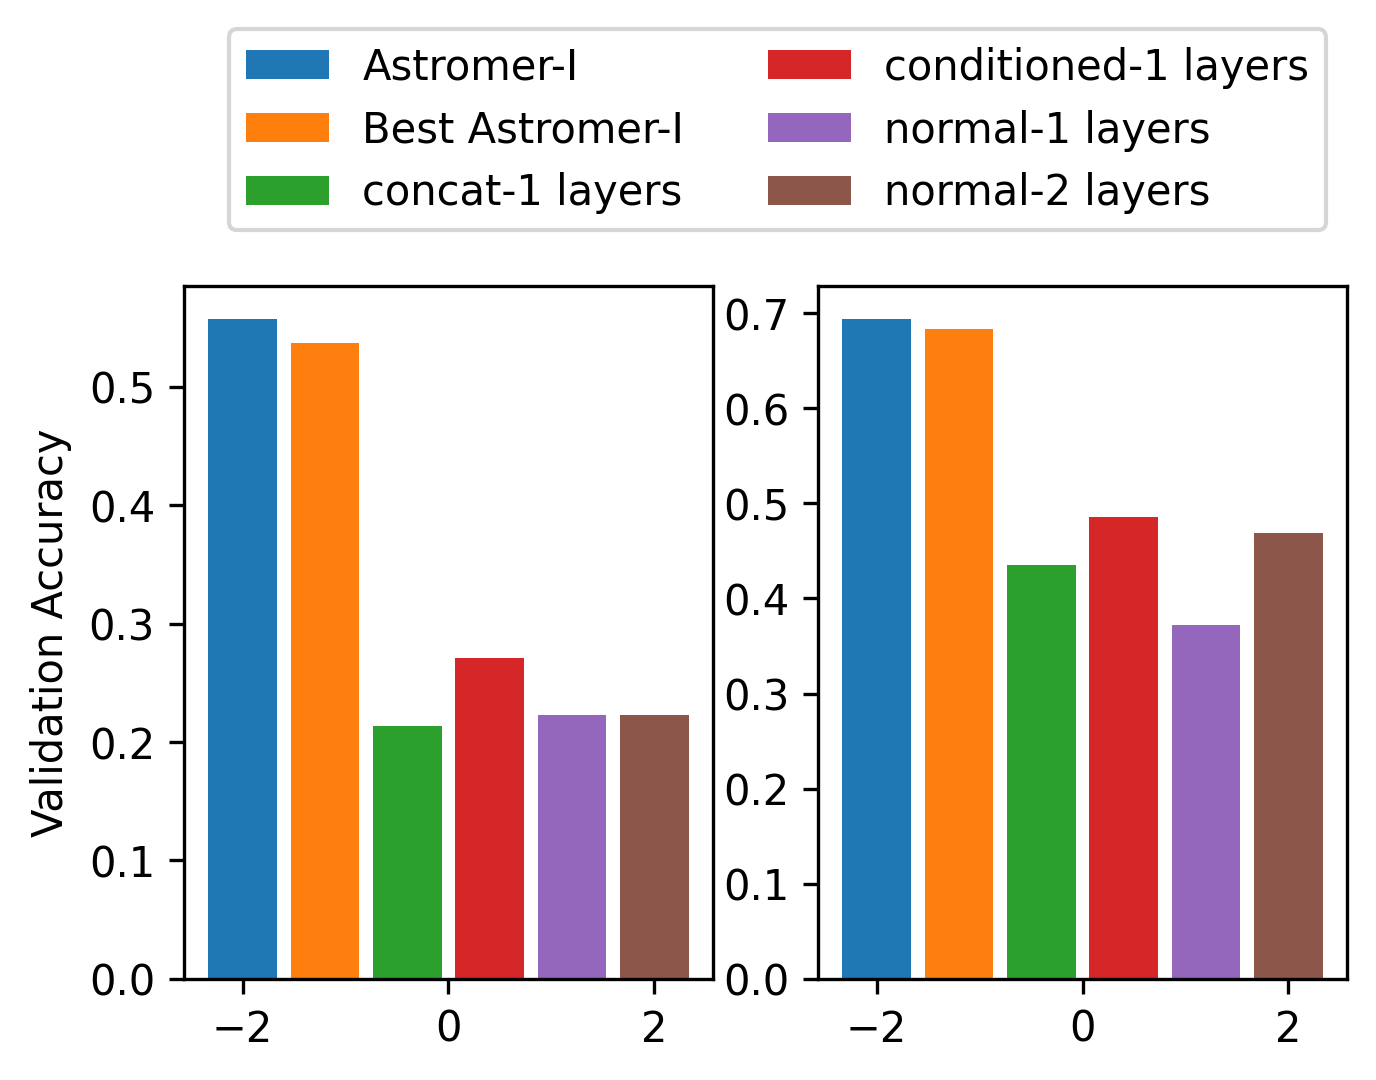

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(5,3), dpi=300)
ds_names = ['MACHO', 'ATLAS']
min_v = -2
max_v = 2
separators = np.linspace(min_v, max_v, n_models+2)
print(separators)
for k, ds in enumerate(['alcock', 'atlas']):
    x_range = np.arange(n_models+2)
    
    # =================================
    # ========= Paper =====================
    astromer_old = pd.read_csv('./presentation/experiments/astromer_0/backup/errata/results/paper/{}/classification/metrics.csv'.format(ds))
    acc_old = astromer_old[(astromer_old['model'] == 'mlp_att') & \
                           (astromer_old['spc'] == 20) & \
                           (astromer_old['sci_case'] == 'a')][['val_acc']].mean().values[0]
    axes[k].bar(separators[0],acc_old, (max_v-min_v)/(n_models+2), label = 'Astromer-I')
    # =================================
    # ========= BEST Astromer I ===========
    selected = astromer_0_best[astromer_0_best['dataset_to_ft']==ds]
    
    acc_best = selected['epoch/val_accuracy'].values[0]
    axes[k].bar(separators[1], acc_best, (max_v-min_v)/(n_models+2), label = 'Best Astromer-I')
    # =================================
    # ========= Astromer II ===========
    current = astromer_2[astromer_2['subdataset'] == ds]
    current = current.groupby(['encoder_mode', 'layers'])['clf_val_acc'].mean().reset_index()

    count = 2
    for index, row in current.iterrows():
        lab = '{}-{} layers'.format(row['encoder_mode'], row['layers'])
        value = float(row['clf_val_acc'])
        axes[k].bar(separators[count], value, (max_v-min_v)/(n_models+2), label = lab)
        count+=1



axes[-1].legend(bbox_to_anchor=(1, 1.4), ncols=2)
axes[0].set_ylabel('Validation Accuracy')